<a href="https://colab.research.google.com/github/upadhyan/Titanic-Kaggle-Competition/blob/main/titanic_competition_submission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Titanic Competition Submission
Before running any code, lets import the relevant packages


In [199]:
%cd /content/drive/My\ Drive/Colab\ Notebooks/Titanic
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cvxpy as cvx # optimization package
import re # working with strings
from statsmodels.stats.proportion import proportions_ztest # statistical testing
import matplotlib.pyplot as plt # graphs
from sklearn.ensemble import RandomForestClassifier # Random Forest prediction
from sklearn.naive_bayes import GaussianNB # Naive-Bayes
from sklearn.linear_model import LogisticRegression # Logistic Regression
from sklearn.metrics import accuracy_score # Evaluating Predictions
from sklearn.metrics import classification_report # Evaluating Predictions


/content/drive/My Drive/Colab Notebooks/Titanic


## Importing and Viewing Data

In [200]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [201]:
print(f'Train Set. # of rows = {train.shape[0]}')
print(train.columns)
train.head()

Train Set. # of rows = 891
Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [202]:
print(f'Test Set. # of rows = {test.shape[0]}')
print(test.columns)
test.head()

Test Set. # of rows = 418
Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


# Initial Data Processing and Cleaning

## NaN and Null Values

Lets first handle NaN values in the dataset. A good starting point is counting the number of NaN values in each column

In [203]:
train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

It seems like `Age`, `Cabin`, and `Embarked` are the only ones with NaN
### Age
Lets start with cleaning up Age by viewing all the NaN values

In [204]:
train[train['Age'].isna()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
17,18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S
19,20,1,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C
26,27,0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,NaN,C
28,29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,NaN,Q
...,...,...,...,...,...,...,...,...,...,...,...,...
859,860,0,3,"Razi, Mr. Raihed",male,NaN,0,0,2629,7.2292,NaN,C
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.5500,NaN,S
868,869,0,3,"van Melkebeke, Mr. Philemon",male,NaN,0,0,345777,9.5000,NaN,S
878,879,0,3,"Laleff, Mr. Kristo",male,NaN,0,0,349217,7.8958,NaN,S


There doesn't seem to be any relationship between any of the other features at a first glance (the `Cabin` column is almost all `NaN` but thats because of the properties of the dataset. Now lets see if there is a significant difference in survival proportion between the `NaN` values and the non-`NaN` values. 

$ H_0: \hat{p_{NaN}} - \hat{p_{value}}$

In [205]:
significance = 0.05
sample_success_a, sample_size_a = (410, 500)
sample_success_b, sample_size_b = (379, 400)
successes = np.array([train[train['Age'].isna() & train['Survived'] == 1].shape[0], 
                      train[train['Age'].notna() & train['Survived'] == 1].shape[0]])
samples = np.array([train[train['Age'].isna()].shape[0], 
                    train[train['Age'].notna()].shape[0]])
stat, p_value = proportions_ztest(count=successes, nobs=samples,  alternative='two-sided')
# report
print(f'Proportion of Null Survivors = {successes[0]/samples[0]:.3f}')
print(f'Proportion of Not Null Survivors = {successes[1]/samples[1]:.3f}')

print('z_stat: %0.3f, p_value: %0.3f' % (stat, p_value))
if p_value > significance:
   print ("Fail to reject the null hypothesis - we have nothing else to say")
else:
   print ("Reject the null hypothesis - suggest the alternative hypothesis is true")

Proportion of Null Survivors = 0.294
Proportion of Not Null Survivors = 0.406
z_stat: -2.752, p_value: 0.006
Reject the null hypothesis - suggest the alternative hypothesis is true


Based on this, it seems as if the `NaN` age values in this mean something. It might be valuable to use a seperate method to predict the NaN age values. Lets create a feature to represent this. 

In [206]:
train['NanAge'] = np.where(train['Age'].isna(), 1, 0)
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,NanAge
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0


We also need to fill our `NaN` age values with something, so lets explore the age field a bit more, starting out with just plotting the valid ages and the survival column.

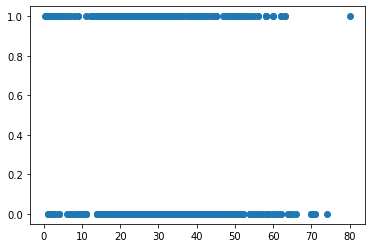

In [207]:
plt.scatter(train[train['Age'].notna()]['Age'], train[train['Age'].notna()]['Survived'])

Lets also create a histogram of people who survived and their ages...

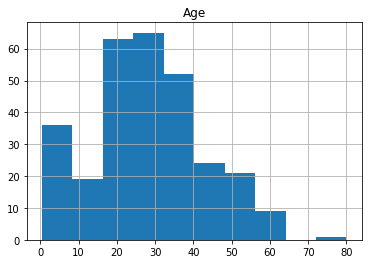

In [208]:
train[train['Age'].notna() & train['Survived'] == 1].hist('Age');

People who didn't survive and their ages...

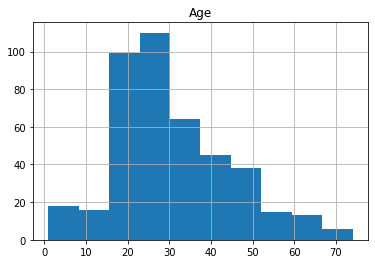

In [209]:
train[train['Age'].notna() & train['Survived'] == 0].hist('Age');

and a histogram to see the distribution of ages in general.

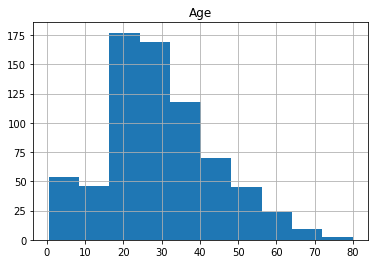

In [210]:
train[train['Age'].notna()].hist('Age');

Looking at these charts, it seems like the younger passengers had a higher proportion of surviving. This indicates that age may be an important factor, therefore its important for us to fill the `NaN` values in. We will populate it with the mean age value. 

In [211]:
train['Age'].fillna(value = train['Age'].mean(), inplace = True)
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,NanAge
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0


### Cabin

Since most values in our dataset have `NaN` for the `Cabin` column, we need to check if being 'NaN' is significant for survival rate, via a hypothesis test using the same null hypothesis as the test for `Age`.

In [212]:
significance = 0.05
sample_success_a, sample_size_a = (410, 500)
sample_success_b, sample_size_b = (379, 400)
successes = np.array([train[train['Cabin'].isna() & train['Survived'] == 1].shape[0], 
                      train[train['Cabin'].notna() & train['Survived'] == 1].shape[0]])
samples = np.array([train[train['Cabin'].isna()].shape[0], 
                    train[train['Cabin'].notna()].shape[0]])
stat, p_value = proportions_ztest(count=successes, nobs=samples,  alternative='two-sided')
# report
print(f'Proportion of Null Survivors = {successes[0]/samples[0]:.3f}')
print(f'Proportion of Not Null Survivors = {successes[1]/samples[1]:.3f}')

print('z_stat: %0.5f, p_value: %0.3f' % (stat, p_value))
if p_value > significance:
   print ("Fail to reject the null hypothesis - we have nothing else to say")
else:
   print ("Reject the null hypothesis - suggest the alternative hypothesis is true")

Proportion of Null Survivors = 0.300
Proportion of Not Null Survivors = 0.667
z_stat: -9.45969, p_value: 0.000
Reject the null hypothesis - suggest the alternative hypothesis is true


So there is a significance in a cabin class being NaN, so lets assign these `NaN` values to a new value. The first step is to strip the numbers from the existing cabins

In [213]:
train['Cabin'] = [re.sub(r'[0-9]*','', str(x)) for x in train['Cabin']]

And now we can print the unique cabin classes.

In [214]:
train['Cabin'].value_counts()

nan        687
C           51
B           36
E           32
D           32
A           15
F            9
B B          7
G            4
C C          4
C C C        4
F G          3
B B B B      2
B B B        2
D D          1
F E          1
T            1
Name: Cabin, dtype: int64

With the wide distribution of counts present for the classes, the imbalance towards most data points having `NaN`, and the significant difference in survivability rates, the best way to handle the `Cabin` column seems to be just to change it to a binary value of `0` for `NaN` and 1 for valid values. 

In [215]:
train['Cabin'] = np.where(train['Cabin'] == 'nan', 0,1)
train['Cabin'].value_counts()

0    687
1    204
Name: Cabin, dtype: int64

### Embarked
Since embarked only has 2 `NaN` values, we will just drop the values and not do anything more.

In [216]:
train = train[train['Embarked'].notna()]

## Other Features
### Fare
Fare is the total cost of the ticket. However, we should take this down to a "Fare per Person" instead of just a fair

In [217]:
train['FPP'] = train['Fare'] / (1 + train['SibSp'] + train['Parch'])
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,NanAge,FPP
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,0,S,0,3.62500
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,1,C,0,35.64165
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,0,S,0,7.92500
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,1,S,0,26.55000
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,0,S,0,8.05000


Now lets see `FPP` compared to the survival rate and get some descriptive statistics on it as well.

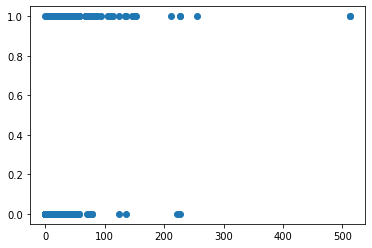

In [218]:
plt.scatter(train['FPP'], train['Survived'])

In [219]:
print(train['FPP'].min())
print(train['FPP'].max())
print(train['FPP'].mean())

0.0
512.3292
19.781203852326865


Looking at the graph, there seems to be a slight skew where the higher FPP's are surviving more. 

### Pclass

Lets first view all of the classes

In [220]:
train['Pclass'].value_counts()

3    491
1    214
2    184
Name: Pclass, dtype: int64

Now lets view the classes based on who survived

In [221]:
train[train['Survived'] == 1]['Pclass'].value_counts()

1    134
3    119
2     87
Name: Pclass, dtype: int64

And lets view all the ratios

In [222]:
train[train['Survived'] == 1]['Pclass'].value_counts() / train['Pclass'].value_counts()

1    0.626168
2    0.472826
3    0.242363
Name: Pclass, dtype: float64

Its apparent that the higher class you are in, the more likely chance you have for survival. 

### Sex
Lets repeat the same steps we did for `Pclass`

In [223]:
train[train['Survived'] == 1]['Sex'].value_counts()

female    231
male      109
Name: Sex, dtype: int64

In [224]:
train['Sex'].value_counts()

male      577
female    312
Name: Sex, dtype: int64

In [225]:
train[train['Survived'] == 1]['Sex'].value_counts() / train['Sex'].value_counts()

female    0.740385
male      0.188908
Name: Sex, dtype: float64

Yup `Sex` is definitely significant. 

We will take one more step here and translate our categories to numbers, to make it easier for us to perform machine learning later.


In [226]:
train['Sex'] = np.where(train['Sex'] == 'male', 1, 0)
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,NanAge,FPP
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,0,S,0,3.62500
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,1,C,0,35.64165
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,0,S,0,7.92500
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,1,S,0,26.55000
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,0,S,0,8.05000


### SibSp and Parch
Lets first take the max of both of these columns

In [227]:
print(train['SibSp'].max())
print(train['Parch'].max())

8
6


Next lets graph them on a scatter plot

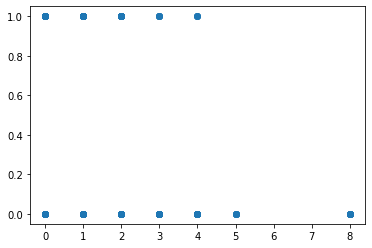

In [228]:
plt.scatter(train['SibSp'], train['Survived']);

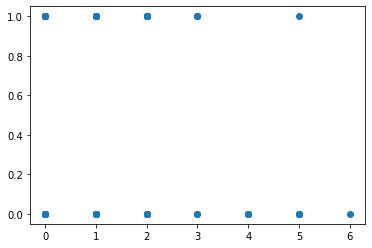

In [229]:
plt.scatter(train['Parch'], train['Survived']);

Its hard to tell if theres a trend in these graph, but we can kind of see that the more people with you, the less likely your chance of survival. 

### Embarked
Lets first see how many unique values are present.

In [230]:
train['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

It seems like there are 3 classes, so we can repeat the steps done for `Classes`

In [231]:
train[train['Survived'] == 1]['Embarked'].value_counts()

S    217
C     93
Q     30
Name: Embarked, dtype: int64

In [232]:
train[train['Survived'] == 1]['Embarked'].value_counts() / train['Embarked'].value_counts()

S    0.336957
C    0.553571
Q    0.389610
Name: Embarked, dtype: float64

There seems to be a a relationship between the percent of people that survive and where they embarked and people who embarked on `C` seem to have a higher survival rate. 

Now we will turn these categories into numbers to standardize everything

In [233]:
train['Embarked'] = train['Embarked'].replace(['S','Q','C'],[3,2,1])
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,NanAge,FPP
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,0,3,0,3.62500
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,1,1,0,35.64165
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,0,3,0,7.92500
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,1,3,0,26.55000
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,0,3,0,8.05000


### Unused Features
Since we are not using `Ticket` and `Name`, we will go ahead and drop that from our data. We will also drop `Fare` since `FPP` is a better indicator for the cost of a ticket.


In [234]:
train = train.drop(['Ticket', 'Name', 'Fare'], axis = 1)
train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Cabin,Embarked,NanAge,FPP
0,1,0,3,1,22.0,1,0,0,3,0,3.62500
1,2,1,1,0,38.0,1,0,1,1,0,35.64165
2,3,1,3,0,26.0,0,0,0,3,0,7.92500
3,4,1,1,0,35.0,1,0,1,3,0,26.55000
4,5,0,3,1,35.0,0,0,0,3,0,8.05000


## Splitting Data

Finally, we will randomly split the data from 'test.csv' into a training set and a validation set. The validation set will have 100 points, and the training set will have the other 789 points. This is to give us an idea of how accurate our solution is since our training set doesn't have truth.

In [235]:
val = train.sample(n=100)
train = train.drop(val.index)
print(val.shape)
print(train.shape)

(100, 11)
(789, 11)


## Prepping Testing Set
Before we do any machine learning and prediction, we should modify the features in the testing set so it matches what we did in the training set

In [254]:
test = pd.read_csv('test.csv')
test['Embarked'].fillna(value = 'Q', inplace = True)
test['Fare'].fillna(value = test['Fare'].mean(), inplace = True)
test['Embarked'] = test['Embarked'].replace(['S','Q','C'],[3,2,1])
test['Sex'] = np.where(test['Sex'] == 'male', 1, 0)
test['FPP'] = test['Fare'] / (1 + test['SibSp'] + test['Parch'])
test['Cabin'] = np.where(test['Cabin'].isna(), 0,1)
test['NanAge'] = np.where(test['Age'].isna(), 1, 0)
test['Age'].fillna(value = train['Age'].mean(), inplace = True)
test = test.drop(['Ticket', 'Name', 'Fare'], axis = 1)

In [255]:
test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Cabin,Embarked,FPP,NanAge
0,892,3,1,34.5,0,0,0,2,7.829200,0
1,893,3,0,47.0,1,0,0,3,3.500000,0
2,894,2,1,62.0,0,0,0,2,9.687500,0
3,895,3,1,27.0,0,0,0,3,8.662500,0
4,896,3,0,22.0,1,1,0,3,4.095833,0


# Machine Learning
This next section will be our machine learning section. In this section we will be actually predicting our classes. Our approach will be an ensemble approach where we will use a few different methods:

*   **Random Forest Classifier (using everything)-** A random forest is good for this problem since we have  discrete numerical, continous numerical, and categorical data, and this is the easiest way to detect trends that may be present in all types of data that are not covered by the other two methods. 
*   **Naive-Bayes (using `Sex`, `Cabin`, and `NanAge`)-** In previous sections, we proved that the different classes in each of these features have statistically different proportions of surviving. We can leverage this statistical proportion difference using Naive-Bayes.
*   **Logistic Classification (using `Age` and `FPP`)-** Logistic classification is probably our best way to leverage our continuous data features. 

After creating predictions for all of this, we will the take the weighted sum using the precision scores for each of the classes
## Random Forest

We will be using `sklearn.ensemble.RandomForestClassifier` and will be predicting on all the features. 



In [238]:
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch','Cabin', 'Embarked','FPP', 'NanAge']
y_train = train['Survived']
rf = RandomForestClassifier(n_estimators=15)
rf.fit(train[features], y_train);
train['Prediction_RF'] = rf.predict(train[features])
val['Prediction_RF']  = rf.predict(val[features])
val.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Cabin,Embarked,NanAge,FPP,Prediction_RF
678,679,0,3,0,43.000000,1,6,0,3,0,5.86250,0
655,656,0,2,1,24.000000,2,0,0,3,0,24.50000,0
451,452,0,3,1,29.699118,1,0,0,3,1,9.98335,0
862,863,1,1,0,48.000000,0,0,1,3,0,25.92920,1
12,13,0,3,1,20.000000,0,0,0,3,0,8.05000,0


Now that we have our prediction, we need to check the accuracy of our solution, as well as notice any behaviors regarding the classification. To do this, we will be using `sklearn.metrics.classification_report` and `sklearn.metrics.accuracy_score`.

First lets get these metrics for our training data

In [239]:
test_RF_classification_report = classification_report(train['Survived'], train['Prediction_RF'], output_dict= True)
val_RF_classification_report = classification_report(val['Survived'], val['Prediction_RF'], output_dict= True)
print('Test Classification Report')
print(test_RF_classification_report)
print('Validation Classification Report')
print(val_RF_classification_report)
print(val_RF_classification_report['accuracy'])

Test Classification Report
{'0': {'precision': 0.9778672032193159, 'recall': 0.9878048780487805, 'f1-score': 0.9828109201213346, 'support': 492}, '1': {'precision': 0.9794520547945206, 'recall': 0.9629629629629629, 'f1-score': 0.9711375212224109, 'support': 297}, 'accuracy': 0.9784537389100126, 'macro avg': {'precision': 0.9786596290069183, 'recall': 0.9753839205058716, 'f1-score': 0.9769742206718728, 'support': 789}, 'weighted avg': {'precision': 0.978463782329374, 'recall': 0.9784537389100126, 'f1-score': 0.9784167509540591, 'support': 789}}
Validation Classification Report
{'0': {'precision': 0.8, 'recall': 0.9122807017543859, 'f1-score': 0.8524590163934427, 'support': 57}, '1': {'precision': 0.8571428571428571, 'recall': 0.6976744186046512, 'f1-score': 0.7692307692307693, 'support': 43}, 'accuracy': 0.82, 'macro avg': {'precision': 0.8285714285714285, 'recall': 0.8049775601795186, 'f1-score': 0.8108448928121059, 'support': 100}, 'weighted avg': {'precision': 0.8245714285714285, 're


## Naive Bayes


In [240]:
features = ['Sex', 'Cabin', 'NanAge']
y_train = train['Survived']
nb = GaussianNB()
nb.fit(train[features], y_train)
train['Prediction_NB'] = nb.predict(train[features])
val['Prediction_NB'] = nb.predict(val[features])
val.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Cabin,Embarked,NanAge,FPP,Prediction_RF,Prediction_NB
678,679,0,3,0,43.000000,1,6,0,3,0,5.86250,0,1
655,656,0,2,1,24.000000,2,0,0,3,0,24.50000,0,0
451,452,0,3,1,29.699118,1,0,0,3,1,9.98335,0,0
862,863,1,1,0,48.000000,0,0,1,3,0,25.92920,1,1
12,13,0,3,1,20.000000,0,0,0,3,0,8.05000,0,0


In [241]:
test_NB_classification_report = classification_report(train['Survived'], train['Prediction_NB'], output_dict= True)
val_NB_classification_report = classification_report(val['Survived'], val['Prediction_NB'], output_dict= True)
print(test_NB_classification_report)
print(val_NB_classification_report)
print(val_NB_classification_report['accuracy'])

{'0': {'precision': 0.8544600938967136, 'recall': 0.7398373983739838, 'f1-score': 0.7930283224400873, 'support': 492}, '1': {'precision': 0.6473829201101928, 'recall': 0.7912457912457912, 'f1-score': 0.7121212121212122, 'support': 297}, 'accuracy': 0.7591888466413181, 'macro avg': {'precision': 0.7509215070034532, 'recall': 0.7655415948098875, 'f1-score': 0.7525747672806498, 'support': 789}, 'weighted avg': {'precision': 0.7765108915968446, 'recall': 0.7591888466413181, 'f1-score': 0.7625727942211951, 'support': 789}}
{'0': {'precision': 0.8928571428571429, 'recall': 0.8771929824561403, 'f1-score': 0.8849557522123894, 'support': 57}, '1': {'precision': 0.8409090909090909, 'recall': 0.8604651162790697, 'f1-score': 0.8505747126436781, 'support': 43}, 'accuracy': 0.87, 'macro avg': {'precision': 0.8668831168831169, 'recall': 0.868829049367605, 'f1-score': 0.8677652324280338, 'support': 100}, 'weighted avg': {'precision': 0.8705194805194806, 'recall': 0.87, 'f1-score': 0.8701719051978435, 

## Logistic Classification

In [242]:
features = ['FPP', 'Age']
y_train = train['Survived']
lr = LogisticRegression()
lr.fit(train[features], y_train)
train['Prediction_LR'] = lr.predict(train[features])
val['Prediction_LR'] = lr.predict(val[features])
val.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Cabin,Embarked,NanAge,FPP,Prediction_RF,Prediction_NB,Prediction_LR
678,679,0,3,0,43.000000,1,6,0,3,0,5.86250,0,1,0
655,656,0,2,1,24.000000,2,0,0,3,0,24.50000,0,0,0
451,452,0,3,1,29.699118,1,0,0,3,1,9.98335,0,0,0
862,863,1,1,0,48.000000,0,0,1,3,0,25.92920,1,1,0
12,13,0,3,1,20.000000,0,0,0,3,0,8.05000,0,0,0


In [243]:
test_LR_classification_report = classification_report(train['Survived'], train['Prediction_LR'], output_dict= True)
val_LR_classification_report = classification_report(val['Survived'], val['Prediction_LR'], output_dict= True)
print(test_LR_classification_report)
print(val_LR_classification_report)
print(val_LR_classification_report['accuracy'])

{'0': {'precision': 0.6633663366336634, 'recall': 0.9532520325203252, 'f1-score': 0.7823185988323604, 'support': 492}, '1': {'precision': 0.7195121951219512, 'recall': 0.19865319865319866, 'f1-score': 0.3113456464379947, 'support': 297}, 'accuracy': 0.6692015209125475, 'macro avg': {'precision': 0.6914392658778072, 'recall': 0.5759526155867619, 'f1-score': 0.5468321226351776, 'support': 789}, 'weighted avg': {'precision': 0.6845010894486463, 'recall': 0.6692015209125475, 'f1-score': 0.6050322023036828, 'support': 789}}
{'0': {'precision': 0.6111111111111112, 'recall': 0.9649122807017544, 'f1-score': 0.7482993197278912, 'support': 57}, '1': {'precision': 0.8, 'recall': 0.18604651162790697, 'f1-score': 0.3018867924528302, 'support': 43}, 'accuracy': 0.63, 'macro avg': {'precision': 0.7055555555555556, 'recall': 0.5754793961648307, 'f1-score': 0.5250930560903607, 'support': 100}, 'weighted avg': {'precision': 0.6923333333333334, 'recall': 0.63, 'f1-score': 0.556341932999615, 'support': 10

## Ensemble

In [244]:
weights_RF = [val_RF_classification_report['0']['precision'], val_RF_classification_report['1']['precision']]
weights_NB = [val_NB_classification_report['0']['precision'], val_NB_classification_report['1']['precision']]
weights_LR = [val_LR_classification_report['0']['precision'], val_LR_classification_report['1']['precision']]

train['RF_weight'] = train['Prediction_RF'].apply(lambda a: weights_RF[a])
train['NB_weight'] = train['Prediction_RF'].apply(lambda a: weights_NB[a])
train['LR_weight'] = train['Prediction_RF'].apply(lambda a: weights_LR[a])
train['total_weight'] = train['RF_weight'] + train['NB_weight'] + train['LR_weight']
train['weighted_val'] = (train['Prediction_RF'] * train['RF_weight'] +
                         train['Prediction_NB'] * train['NB_weight'] + 
                         train['Prediction_LR'] * train['LR_weight'] )/train['total_weight']
train['Final_Prediction'] = train['weighted_val'].round().astype('int32')


val['RF_weight'] = val['Prediction_RF'].apply(lambda a: weights_RF[a])
val['NB_weight'] = val['Prediction_RF'].apply(lambda a: weights_NB[a])
val['LR_weight'] = val['Prediction_RF'].apply(lambda a: weights_LR[a])
val['total_weight'] = val['RF_weight'] + val['NB_weight'] + val['LR_weight']
val['weighted_val'] = (val['Prediction_RF'] * val['RF_weight'] +
                         val['Prediction_NB'] * val['NB_weight'] + 
                         val['Prediction_LR'] * val['LR_weight'] )/val['total_weight']
val['Final_Prediction'] = val['weighted_val'].round().astype('int32')
val.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Cabin,Embarked,NanAge,FPP,Prediction_RF,Prediction_NB,Prediction_LR,RF_weight,NB_weight,LR_weight,total_weight,weighted_val,Final_Prediction
678,679,0,3,0,43.000000,1,6,0,3,0,5.86250,0,1,0,0.800000,0.892857,0.611111,2.303968,0.38753,0
655,656,0,2,1,24.000000,2,0,0,3,0,24.50000,0,0,0,0.800000,0.892857,0.611111,2.303968,0.00000,0
451,452,0,3,1,29.699118,1,0,0,3,1,9.98335,0,0,0,0.800000,0.892857,0.611111,2.303968,0.00000,0
862,863,1,1,0,48.000000,0,0,1,3,0,25.92920,1,1,0,0.857143,0.840909,0.800000,2.498052,0.67975,1
12,13,0,3,1,20.000000,0,0,0,3,0,8.05000,0,0,0,0.800000,0.892857,0.611111,2.303968,0.00000,0


In [245]:
print('----Training Classification Report')
print(classification_report(train['Survived'], train['Final_Prediction']))
print('----Validation Classification Report')
print(classification_report(val['Survived'], val['Final_Prediction']))

----Training Classification Report
              precision    recall  f1-score   support

           0       0.89      0.97      0.93       492
           1       0.95      0.80      0.87       297

    accuracy                           0.91       789
   macro avg       0.92      0.89      0.90       789
weighted avg       0.91      0.91      0.91       789

----Validation Classification Report
              precision    recall  f1-score   support

           0       0.82      0.95      0.88        57
           1       0.91      0.72      0.81        43

    accuracy                           0.85       100
   macro avg       0.86      0.83      0.84       100
weighted avg       0.86      0.85      0.85       100



## Final Prediction

In [256]:
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch','Cabin', 'Embarked','FPP', 'NanAge']
test['Prediction_RF'] = rf.predict(test[features])
features = ['Sex', 'Cabin', 'NanAge']
test['Prediction_NB'] = nb.predict(test[features])
features = ['FPP', 'Age']
test['Prediction_LR'] = lr.predict(test[features])
test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Cabin,Embarked,FPP,NanAge,Prediction_RF,Prediction_NB,Prediction_LR
0,892,3,1,34.5,0,0,0,2,7.829200,0,0,0,0
1,893,3,0,47.0,1,0,0,3,3.500000,0,0,1,0
2,894,2,1,62.0,0,0,0,2,9.687500,0,0,0,0
3,895,3,1,27.0,0,0,0,3,8.662500,0,0,0,0
4,896,3,0,22.0,1,1,0,3,4.095833,0,0,1,0


In [257]:
test['RF_weight'] = test['Prediction_RF'].apply(lambda a: weights_RF[a])
test['NB_weight'] = test['Prediction_RF'].apply(lambda a: weights_NB[a])
test['LR_weight'] = test['Prediction_RF'].apply(lambda a: weights_LR[a])
test['total_weight'] = test['RF_weight'] + test['NB_weight'] + test['LR_weight']
test['weighted_test'] = (test['Prediction_RF'] * test['RF_weight'] +
                         test['Prediction_NB'] * test['NB_weight'] + 
                         test['Prediction_LR'] * test['LR_weight'] )/test['total_weight']
test['Survived'] = test['weighted_test'].round().astype('int32')
test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Cabin,Embarked,FPP,NanAge,Prediction_RF,Prediction_NB,Prediction_LR,RF_weight,NB_weight,LR_weight,total_weight,weighted_test,Survived
0,892,3,1,34.5,0,0,0,2,7.829200,0,0,0,0,0.8,0.892857,0.611111,2.303968,0.00000,0
1,893,3,0,47.0,1,0,0,3,3.500000,0,0,1,0,0.8,0.892857,0.611111,2.303968,0.38753,0
2,894,2,1,62.0,0,0,0,2,9.687500,0,0,0,0,0.8,0.892857,0.611111,2.303968,0.00000,0
3,895,3,1,27.0,0,0,0,3,8.662500,0,0,0,0,0.8,0.892857,0.611111,2.303968,0.00000,0
4,896,3,0,22.0,1,1,0,3,4.095833,0,0,1,0,0.8,0.892857,0.611111,2.303968,0.38753,0


# Final Output


In [258]:
test.drop(test.columns.difference(['PassengerId','Survived']), 1, inplace=True)
test.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [259]:
test.to_csv('submission.csv', index = False)